# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [52]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_16D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [53]:
# Parameters
# --- Parameters fof Experiment ---
dim_exp = 16  # Dimension (e.g., 2D, 4D, 8D as in the paper)
data_points_exp = 20000 # Example number of data points
iterations_exp_initial = 1000 # Iterations for initial training phase
iterations_exp_long = 30000 # Iterations for longer training phase
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 50 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers
#eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section ===

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) -  euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [55]:


def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [56]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")


--- Generating Training Data for Concave Quadratic Prior ---
Generated training data: y_j_exp_tensor shape torch.Size([20000, 16]), psi_samples_exp_tensor shape torch.Size([20000, 1])


## Training function

In [57]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [58]:

# --- Train and Plot with L2 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1000):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-4
for i in range(30000):
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---
iteration 0 loss 7079.61767578125
iteration 500 loss 200.95372009277344
iteration 0 loss 131.5131072998047
iteration 500 loss 115.69038391113281
iteration 1000 loss 106.18367767333984
iteration 1500 loss 101.04796600341797
iteration 2000 loss 98.20223236083984
iteration 2500 loss 96.09491729736328
iteration 3000 loss 93.94873046875
iteration 3500 loss 91.42794036865234
iteration 4000 loss 88.50971984863281
iteration 4500 loss 85.11843872070312
iteration 5000 loss 81.23587799072266
iteration 5500 loss 76.86334228515625
iteration 6000 loss 71.74339294433594
iteration 6500 loss 65.47464752197266
iteration 7000 loss 57.391868591308594
iteration 7500 loss 46.31513595581055
iteration 8000 loss 32.190765380859375
iteration 8500 loss 20.46275520324707
iteration 9000 loss 14.618070602416992
iteration 9500 loss 11.562424659729004
iteration 10000 loss 9.717765808105469
iteration 10500 loss 8.55154037475586
iteration 11000 loss 7.7385

L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=16) ---
loss -19.83318519592285
loss -90.76228332519531
loss -129.71043395996094
loss -147.96759033203125
loss -155.11790466308594
loss -157.62826538085938
loss -158.54672241210938
loss -158.86557006835938
loss -158.99339294433594
loss -159.05755615234375
loss -159.09585571289062
loss -159.11587524414062
loss -159.13021850585938
loss -159.14219665527344
loss -159.139892578125
loss -159.1498260498047
loss -159.14784240722656
loss -159.15225219726562
loss -159.15350341796875
loss -159.15597534179688
loss -159.15528869628906
loss -159.15689086914062
loss -159.15728759765625
loss -159.15859985351562
loss -159.15744018554688
loss -159.16177368164062
loss -159.1612548828125
loss -159.1627197265625
loss -159.15994262695312
loss -159.16107177734375
loss -159.16001892089844
loss -159.16128540039062
loss -159.15817260742188
loss -159.16140747070312
loss -159.1621551513672
loss -159.15963745117188
loss -159.1630859375
loss

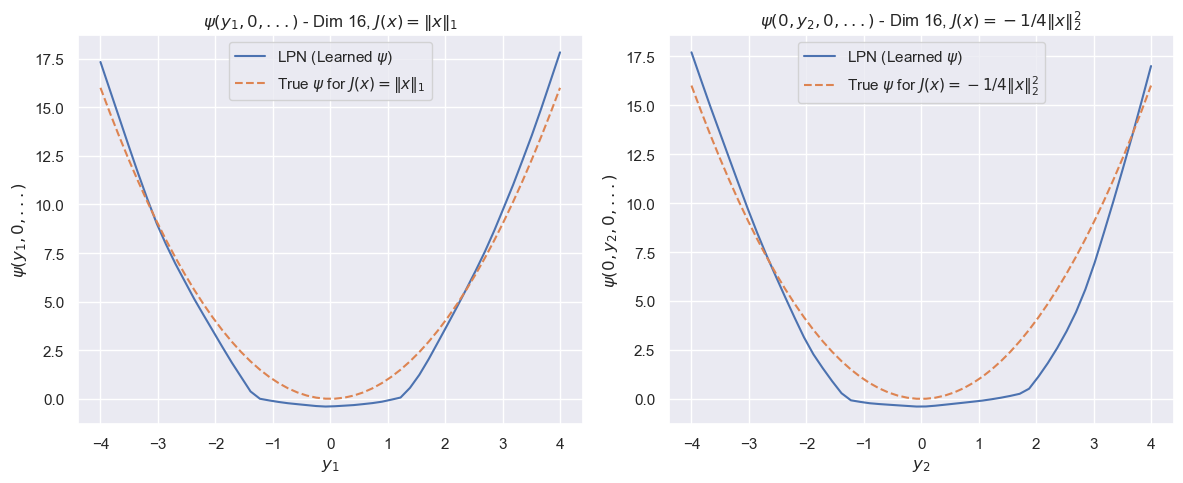

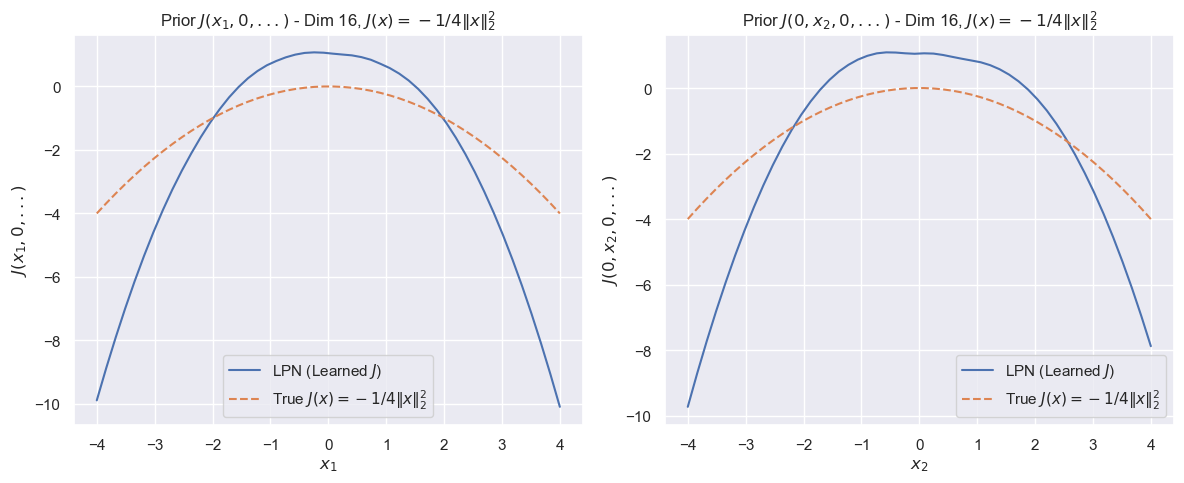

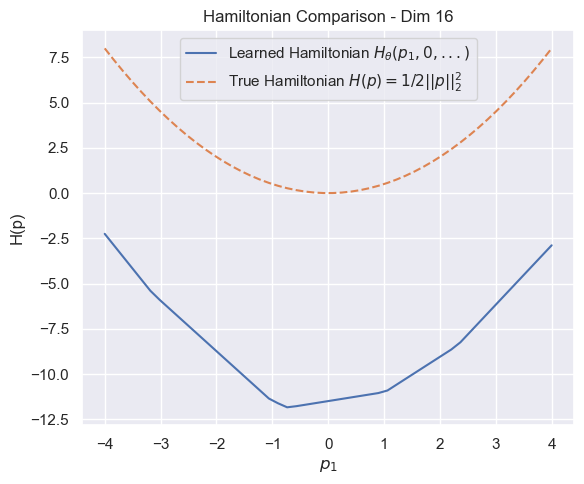

In [59]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)


L1 loss -- Train

In [ ]:

# --- Train and Plot with L1 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l1 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad_l1 = torch.optim.Adam(lpn_model_concave_quad_l1.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1000):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l1, optimizer_concave_quad_l1, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad_l1.param_groups:
    g["lr"] = 1e-4
for i in range(30000):
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l1, optimizer_concave_quad_l1, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l1.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---
iteration 0 loss 7090.306640625
iteration 500 loss 177.59669494628906
iteration 0 loss 134.60272216796875
iteration 500 loss 116.53541564941406
iteration 1000 loss 105.92304992675781
iteration 1500 loss 100.50007629394531
iteration 2000 loss 97.74674987792969
iteration 2500 loss 95.75494384765625
iteration 3000 loss 93.64904022216797
iteration 3500 loss 91.22947692871094
iteration 4000 loss 88.4206771850586
iteration 4500 loss 85.13528442382812
iteration 5000 loss 81.29749298095703
iteration 5500 loss 76.78551483154297
iteration 6000 loss 71.66146850585938
iteration 6500 loss 65.49158477783203
iteration 7000 loss 57.4576301574707
iteration 7500 loss 46.47404861450195
iteration 8000 loss 32.68642807006836
iteration 8500 loss 21.277315139770508
iteration 9000 loss 15.276690483093262
iteration 9500 loss 12.259849548339844
iteration 10000 loss 10.3067045211792
iteration 10500 loss 8.868468284606934
iteration 11000 loss 7.90590

L1 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=16) ---
loss -26.924083709716797
loss -87.21414947509766
loss -129.13607788085938
loss -161.1788330078125
loss -176.12722778320312
loss -181.48617553710938
loss -183.05238342285156
loss -183.57179260253906
loss -183.8140869140625
loss -183.921875
loss -183.9875946044922
loss -184.0274200439453
loss -184.053466796875
loss -184.06912231445312
loss -184.07627868652344
loss -184.07943725585938
loss -184.0863800048828
loss -184.08926391601562
loss -184.09112548828125
loss -184.093994140625
loss -184.09519958496094
loss -184.09674072265625
loss -184.09588623046875
loss -184.10037231445312
loss -184.09584045410156
loss -184.0972137451172
loss -184.093994140625
loss -184.10118103027344
loss -184.0960235595703
loss -184.10133361816406
loss -184.0970916748047
loss -184.0994873046875
loss -184.1001739501953
loss -184.09906005859375
loss -184.09906005859375
loss -184.0979766845703
loss -184.09933471679688
loss -184.10000610

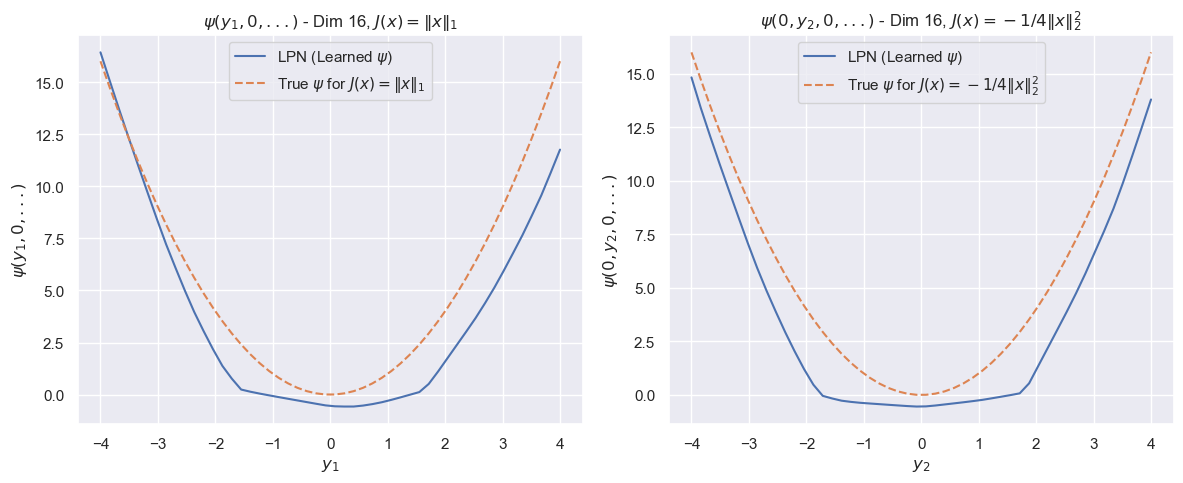

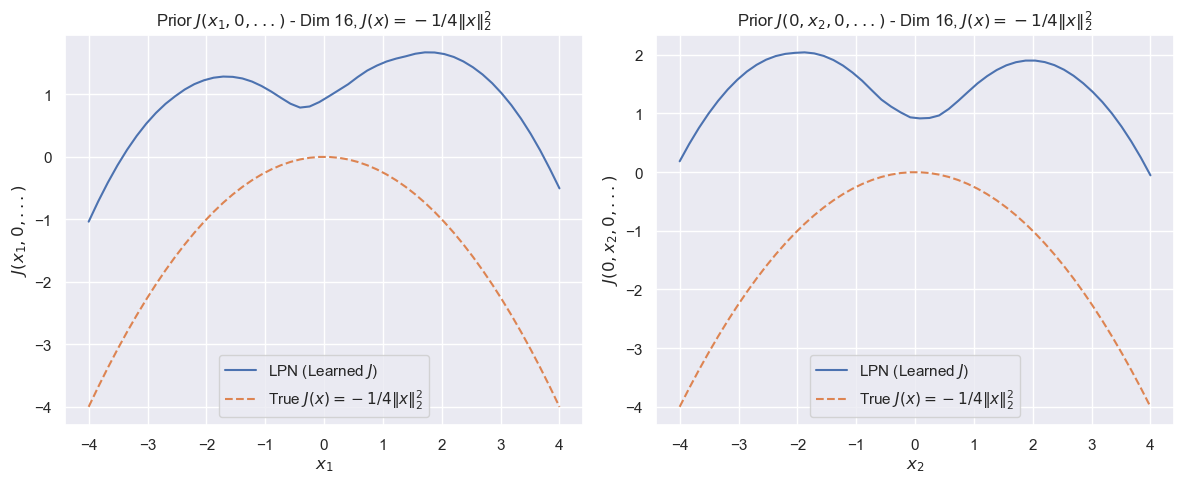

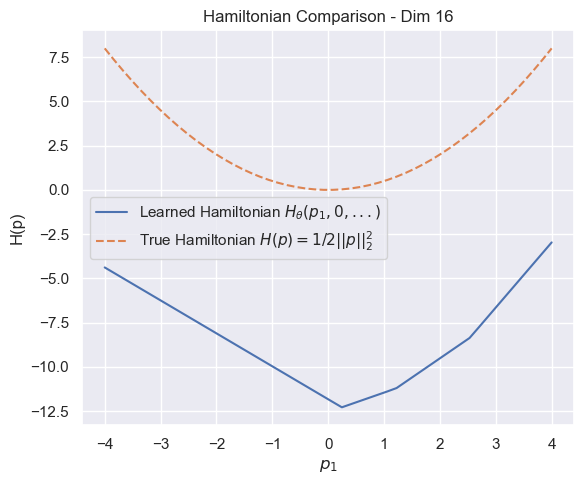

In [45]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l1, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
evaluate_learned_H(lpn_model_concave_quad_l1, a_exp, spacing, dim_exp)


Proximal matching loss.
We perform proximal matching loss with a decreasing sequence of gamma parameters.

gamma = 20 -- Train

In [46]:
# lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
# optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

# loss_type = 0
# gamma_loss = 20

# # set learning rate
# for g in optimizer.param_groups:
#     g["lr"] = 1e-4

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 20 -- Plot

In [47]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 12.5 -- Train

In [48]:
# gamma_loss = 12.5

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(6000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 12.5 -- Plot

In [49]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 10 -- Train

In [50]:
# gamma_loss = 10

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(10000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 10 -- Plot

In [51]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)